# Install detectron2

**References :** https://github.com/facebookresearch/detectron2


In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.1 ; cuda:  cu118
detectron2: 0.6


**Libs**

In [ ]:
# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import ColorMode
import os


##**Personal Goal ❎**

**Here I Am going to personalize the work and get only Human detection as output.**

**The input image will be cropped into N persons detected by Detectron2**

**We will be adding variable N to calculate the occurence of the Humans in the pic**

# Run a pre-trained detectron2 model

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [ ]:
cfg = get_cfg()

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

# Load Model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# Create a predictor
predictor = DefaultPredictor(cfg)

[11/14 15:29:18 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


In [ ]:
# see what we have in Metadata
print(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))

Metadata(name='coco_2017_train', json_file='datasets/coco/annotations/instances_train2017.json', image_root='datasets/coco/train2017', evaluator_type='coco', thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 13: 11, 14: 12, 15: 13, 16: 14, 17: 15, 18: 16, 19: 17, 20: 18, 21: 19, 22: 20, 23: 21, 24: 22, 25: 23, 27: 24, 28: 25, 31: 26, 32: 27, 33: 28, 34: 29, 35: 30, 36: 31, 37: 32, 38: 33, 39: 34, 40: 35, 41: 36, 42: 37, 43: 38, 44: 39, 46: 40, 47: 41, 48: 42, 49: 43, 50: 44, 51: 45, 52: 46, 53: 47, 54: 48, 55: 49, 56: 50, 57: 51, 58: 52, 59: 53, 60: 54, 61: 55, 62: 56, 63: 57, 64: 58, 65: 59, 67: 60, 70: 61, 72: 62, 73: 63, 74: 64, 75: 65, 76: 66, 77: 67, 78: 68, 79: 69, 80: 70, 81: 71, 82: 72, 84: 73, 85: 74, 86: 75, 87: 76, 88: 77, 89: 78, 90: 79}, thing_classes=['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'ca

-> so 0 stands for person

**FILTER PERSON ONLY**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
drive_image_dir ="/content/drive/MyDrive/imgs_test_set" #input Images
output_directory="/content/drive/MyDrive/imgs_test_set/Detectron2_result/cropped_humans" #output Folder
#make sure we have output dir
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

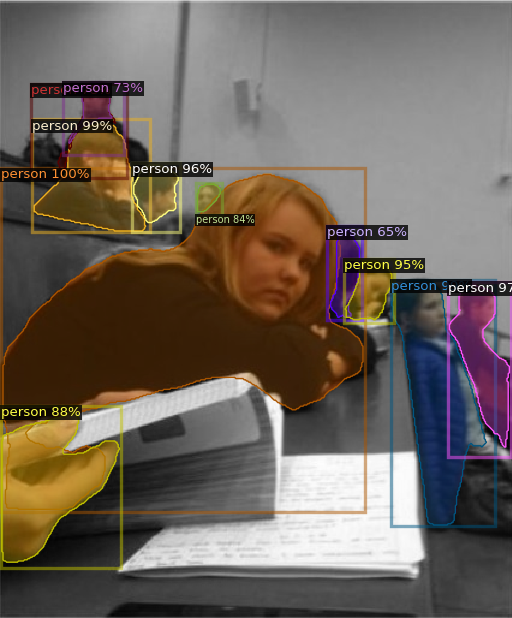

Number of humans in /content/drive/MyDrive/imgs_test_set/1.jpeg: 11


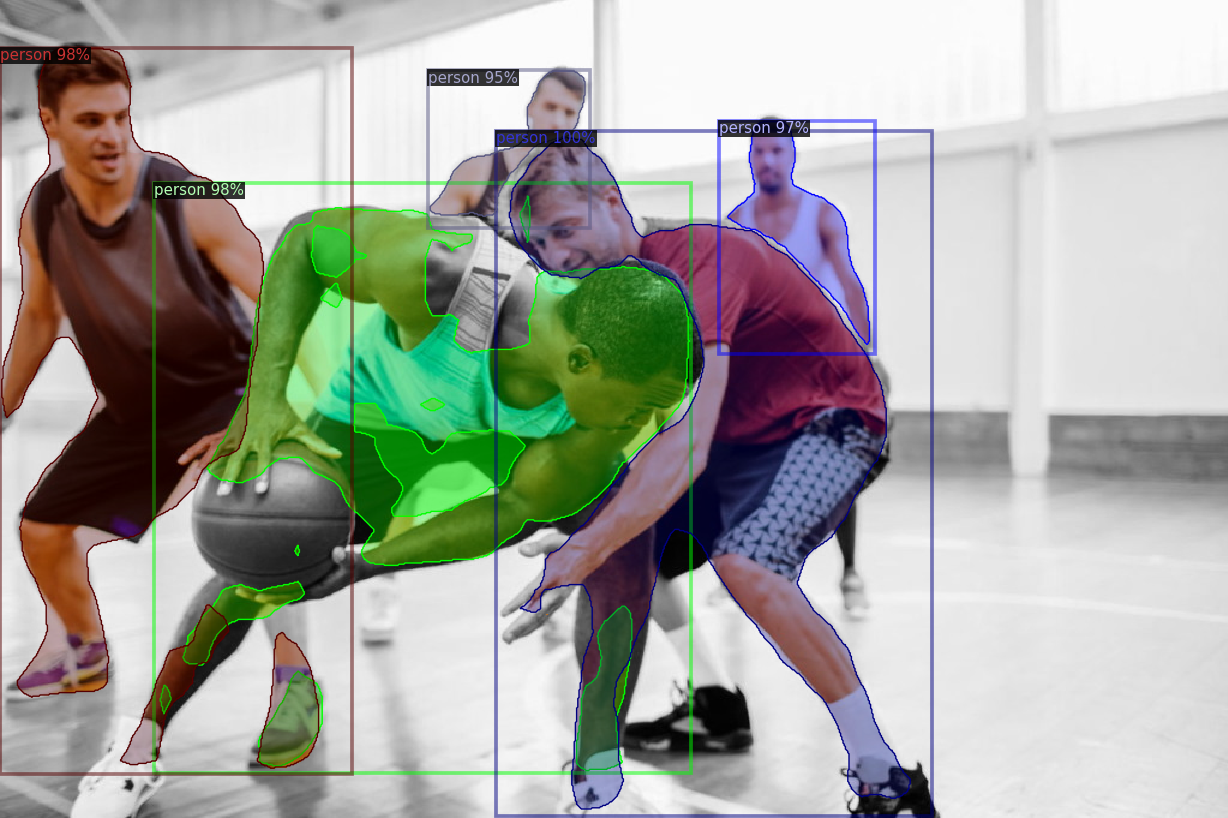

Number of humans in /content/drive/MyDrive/imgs_test_set/2.jpeg: 5


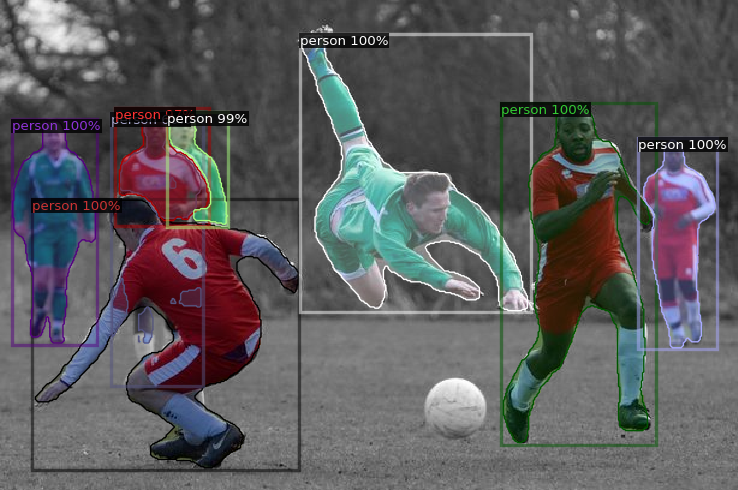

Number of humans in /content/drive/MyDrive/imgs_test_set/3.jpeg: 8


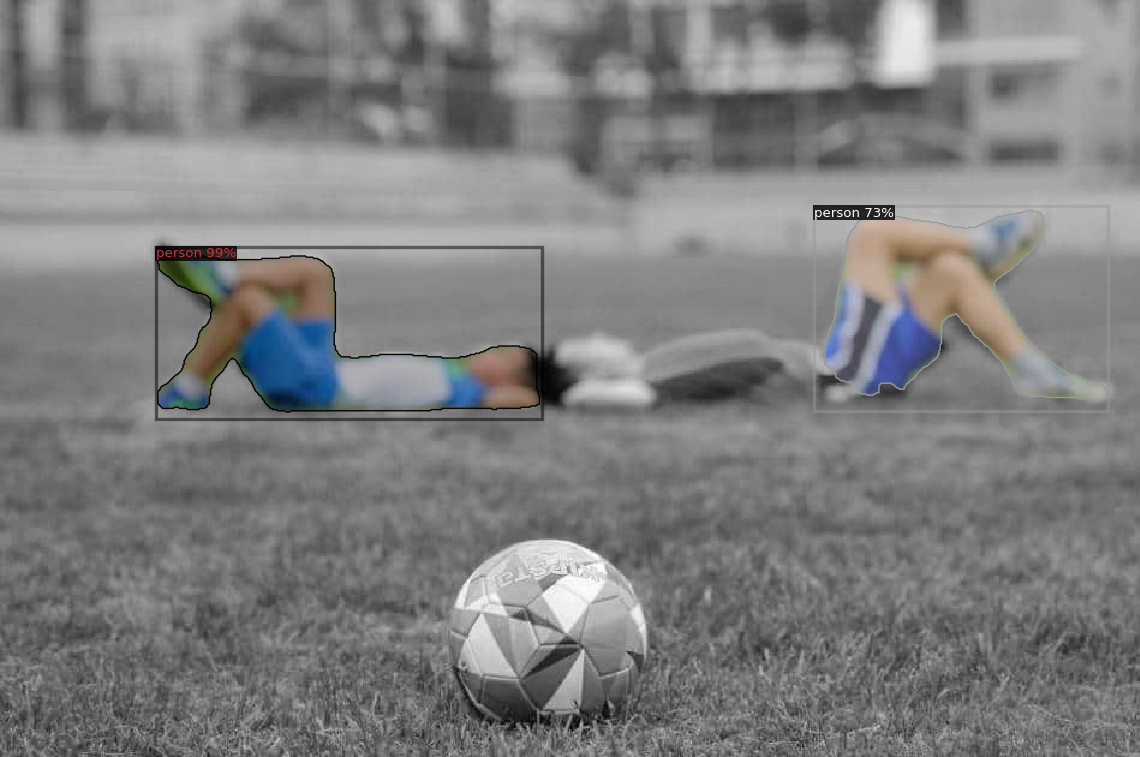

Number of humans in /content/drive/MyDrive/imgs_test_set/4.jpeg: 2


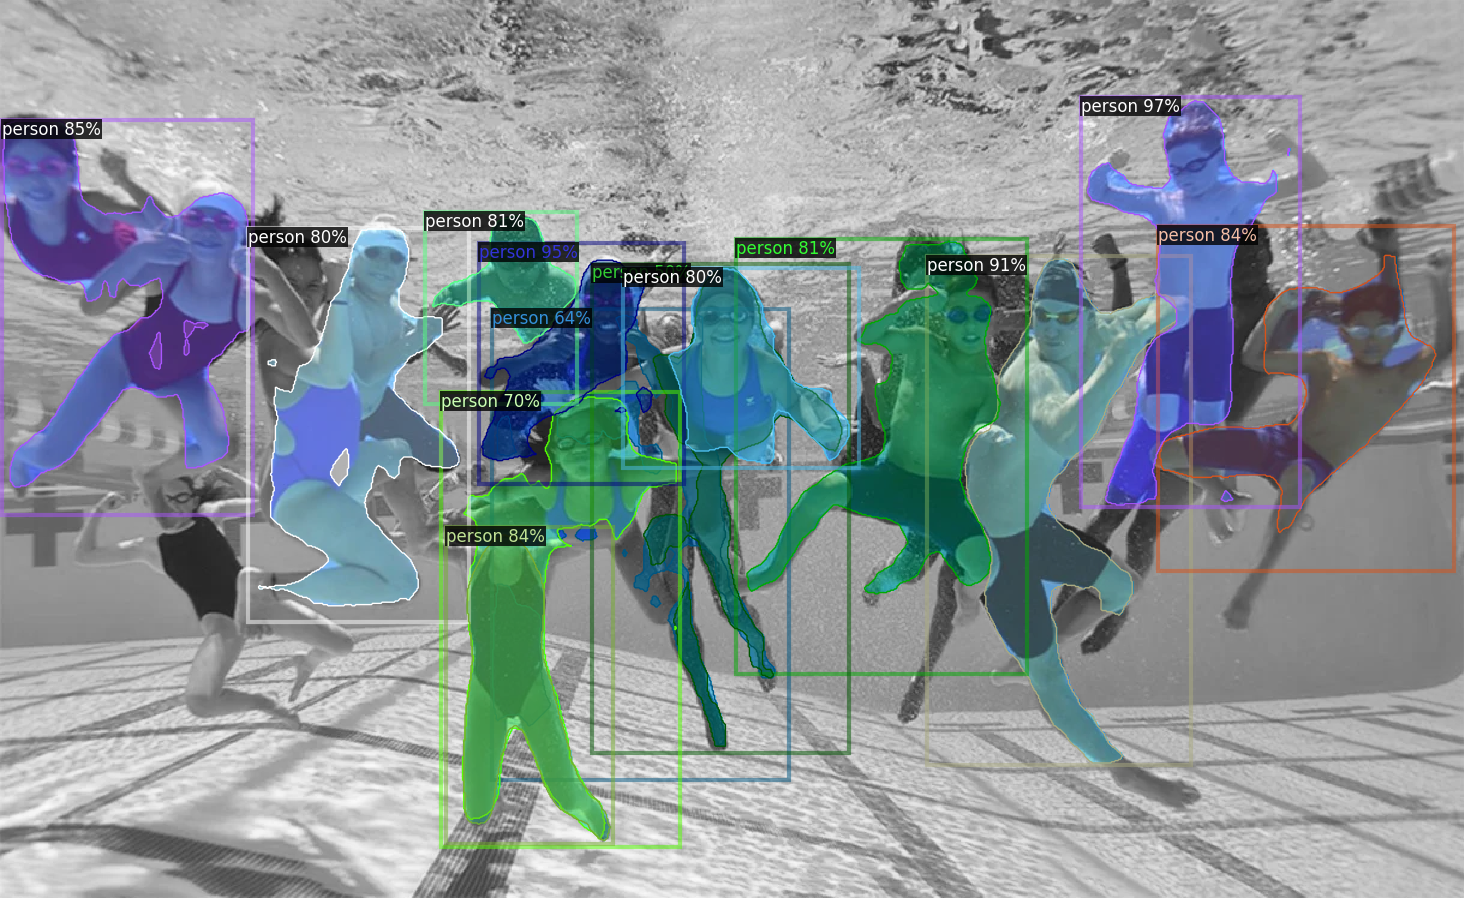

Number of humans in /content/drive/MyDrive/imgs_test_set/5.jpeg: 13


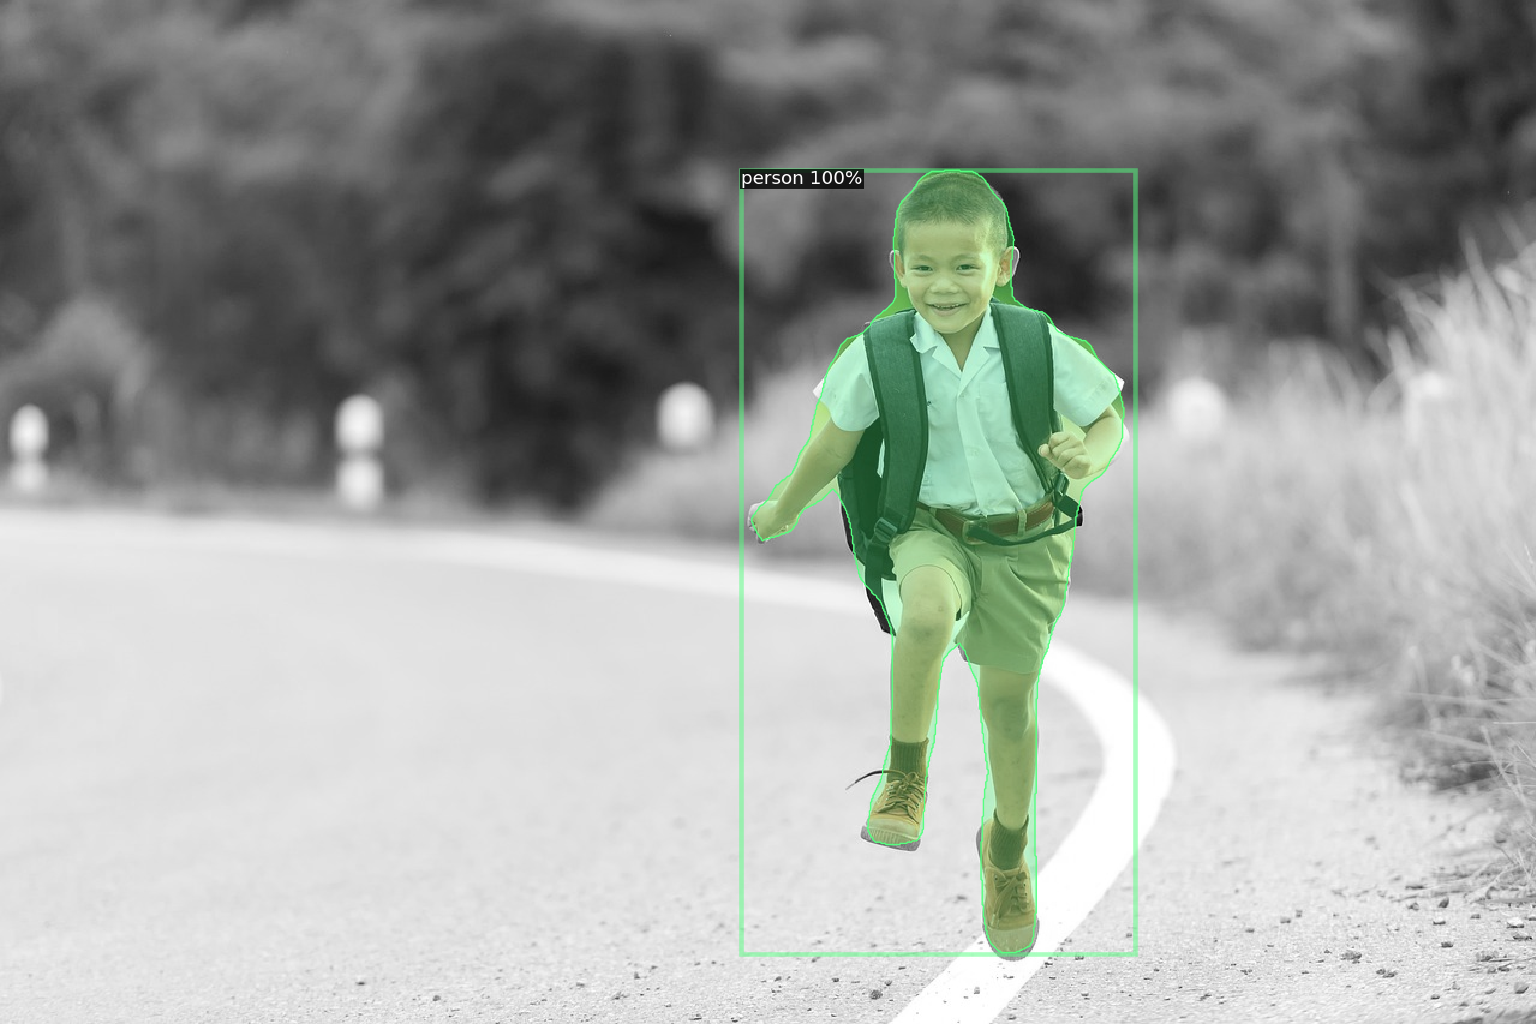

Number of humans in /content/drive/MyDrive/imgs_test_set/boy-1822565_1280.jpeg: 1


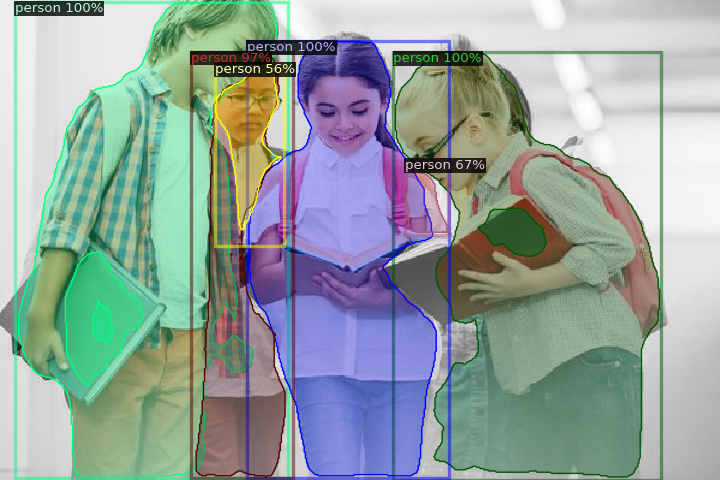

Number of humans in /content/drive/MyDrive/imgs_test_set/cmxseT20wDlQ_s600x600.jpeg: 6


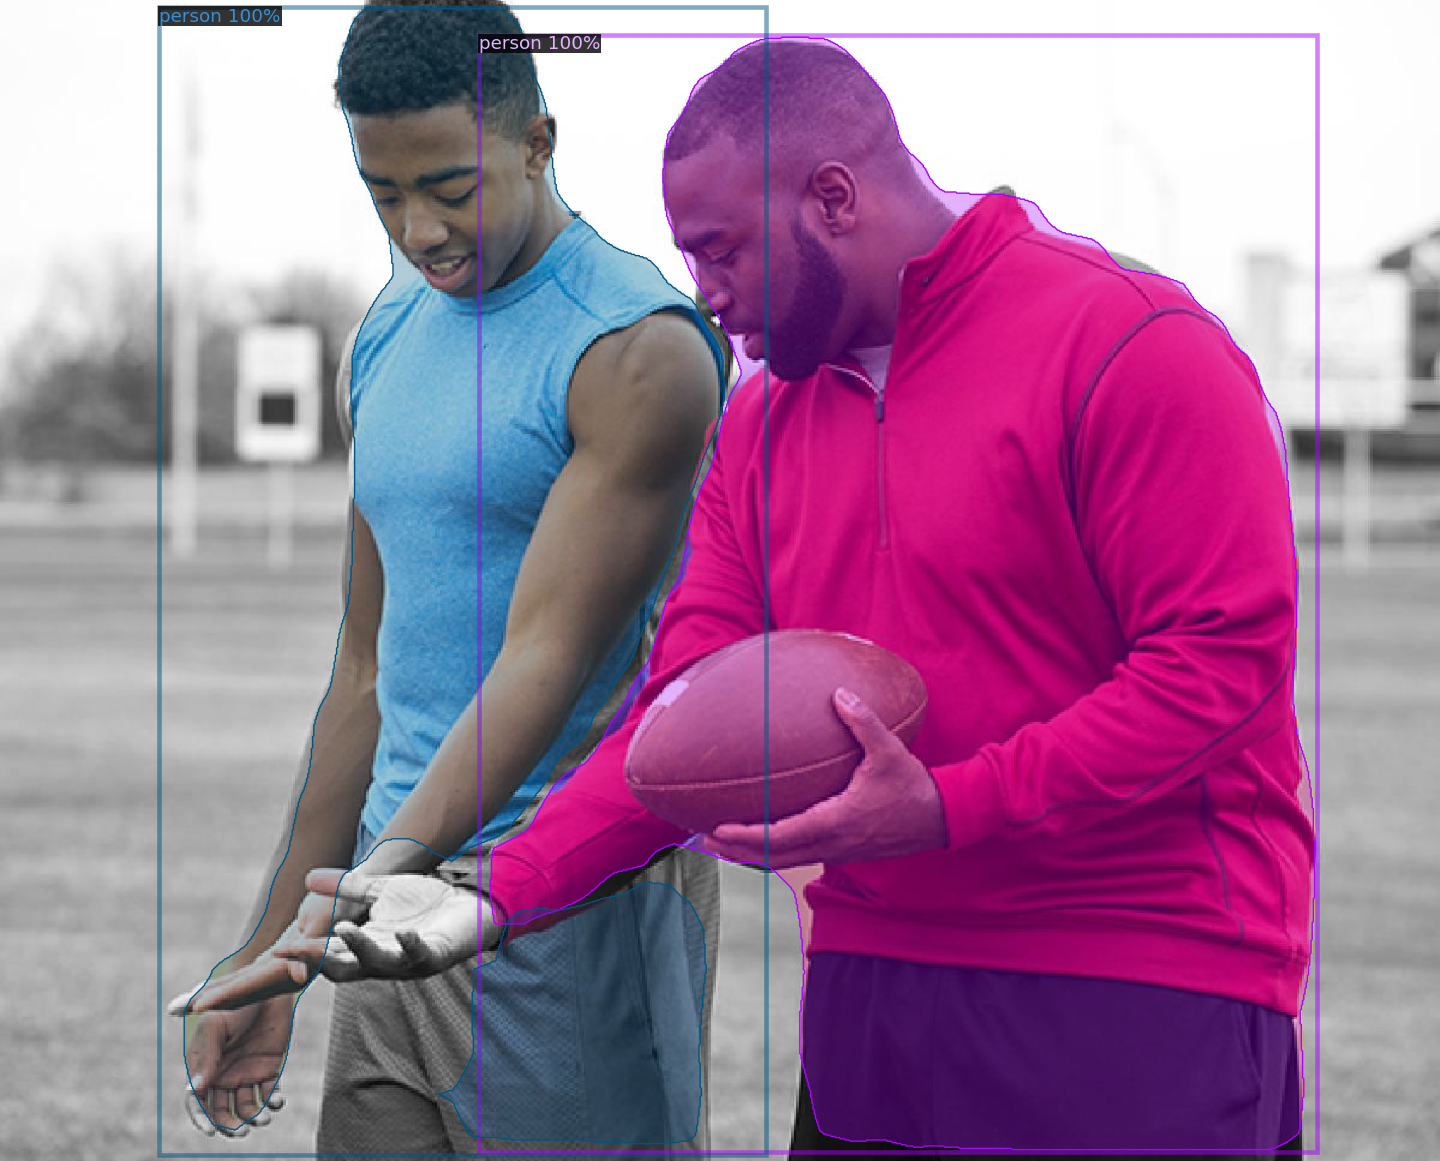

Number of humans in /content/drive/MyDrive/imgs_test_set/coachplayertf.jpeg: 2


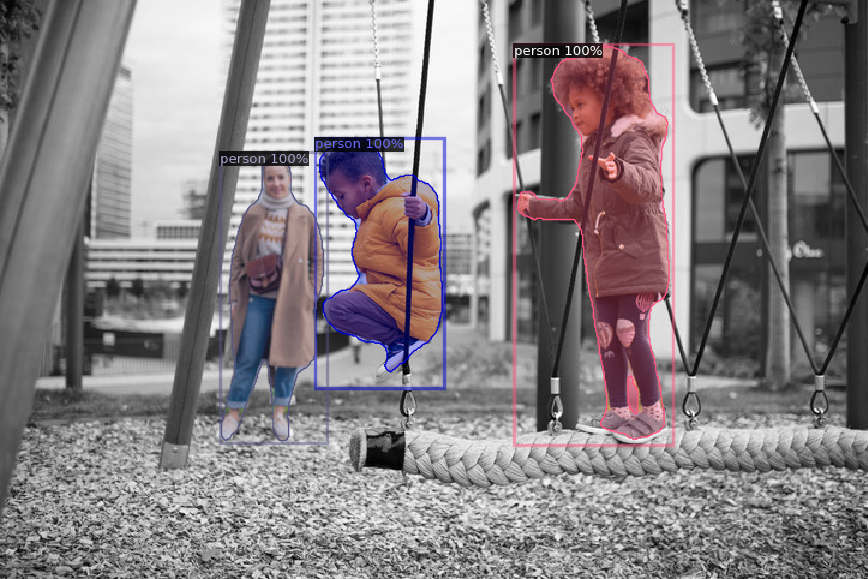

Number of humans in /content/drive/MyDrive/imgs_test_set/fef23683-0b70-49d7-8b32-d11ae842f633.jpeg: 3


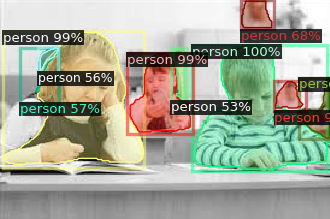

Number of humans in /content/drive/MyDrive/imgs_test_set/images (1).jpeg: 9


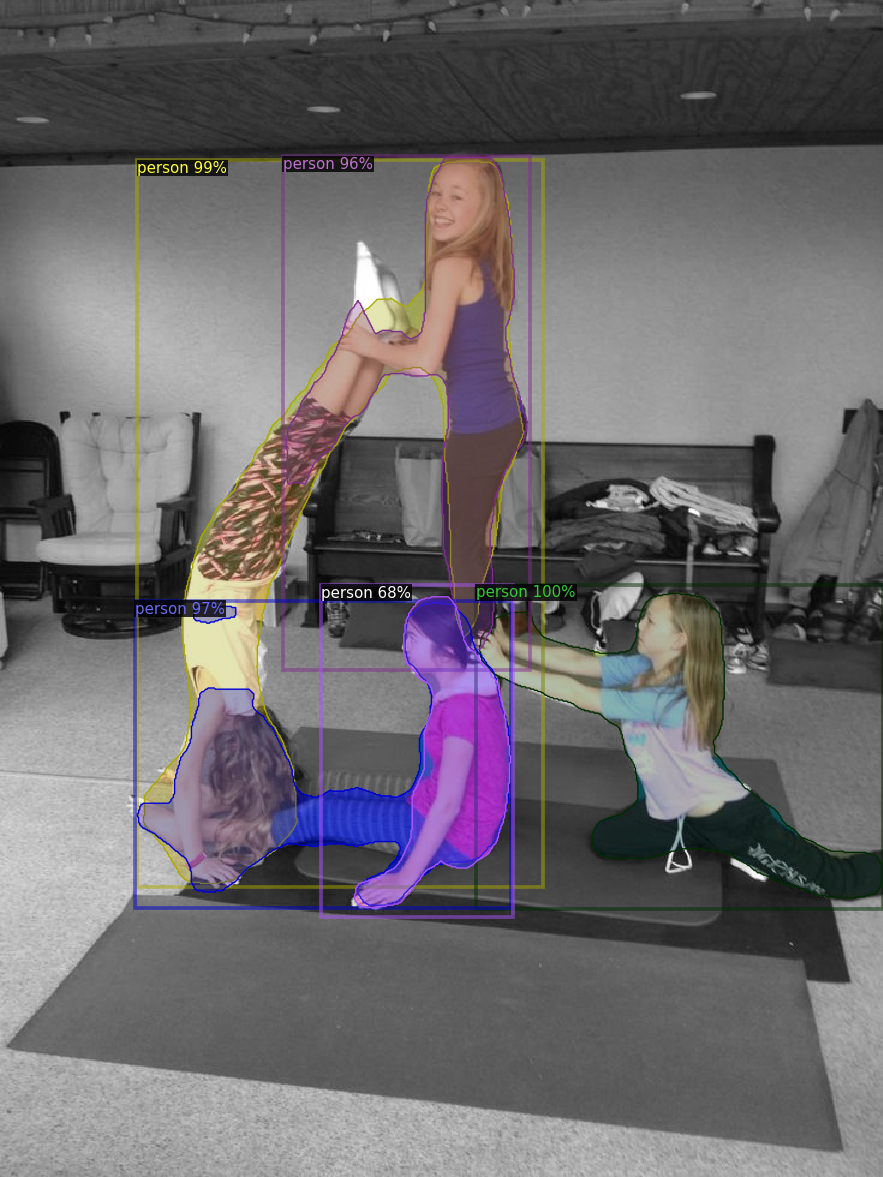

Number of humans in /content/drive/MyDrive/imgs_test_set/input - Copie.jpeg: 5


In [ ]:
# List all image files in the directory in Google Drive
image_files = [os.path.join(drive_image_dir, filename) for filename in os.listdir(drive_image_dir) if filename.endswith(".jpeg")]

for image_path in image_files:
    # Load an image from Google Drive
    im = cv2.imread(image_path)

    # Perform inference on the loaded image
    outputs = predictor(im)

    # Initialize the number of humans detected in the current image
    n_human = 0

    # Create a copy of the original image
    image_with_results = im.copy()

    # Filter predictions to only include "person" class
    filtered_instances = outputs["instances"][outputs["instances"].pred_classes == MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes.index("person")]

    # Update the number of humans detected
    n_human = len(filtered_instances)

    # Create a Visualizer with a specified color mode (display only bounding boxes)
    v = Visualizer(image_with_results[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2, instance_mode=ColorMode.IMAGE_BW)

    # Draw only bounding boxes
    out = v.draw_instance_predictions(filtered_instances.to("cpu"))

    # Display the image with filtered results
    cv2_imshow(out.get_image()[:, :, ::-1])

    # Save cropped images of each detected person
    # Loop through the bounding boxes and save cropped images
    for i, box in enumerate(filtered_instances.pred_boxes.tensor.cpu().numpy()):
        x1, y1, x2, y2 = map(int, box)

        # Crop the person from the original image
        person_cropped = im[y1:y2, x1:x2]

        # Get the original image name without the extension
        image_name = os.path.splitext(os.path.basename(image_path))[0]

        # Save the cropped image in your Google Drive directory with the original image name and person index
        save_path = os.path.join(output_directory, f"{image_name}_person_{i}.jpg")
        cv2.imwrite(save_path, person_cropped)

    # Print the number of humans detected in the current image
    print(f"Number of humans in {image_path}: {n_human}")